# Data Processing and analysis

In [3]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
from tabulate import tabulate
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPythonfrom IPython.display import IFrame

from IPython.display import IFrame

## data processing
first, get the data from functions we wrote in getdata1.py

time series data:
- time_series_covid19_confirmed_US
- time_series_covid19_confirmed_global
- time_series_covid19_deaths_US
- time_series_covid19_deaths_global
- time_series_covid19_recovered_global

cross sectional data:
- csse_covid_19_daily_reports
- csse_covid_19_daily_reports_us

In [4]:
from getdata1 import *

# GET_csse_covid_19_daily_reports()
latest_data_global, prev_data_global = GET_csse_covid_19_daily_reports_my('global')
latest_data_us, prev_data_us = GET_csse_covid_19_daily_reports_my('us')

# GET_csse_covid_19_time_series()
time_series_covid19_confirmed_US, time_series_covid19_confirmed_global, time_series_covid19_deaths_US, time_series_covid19_deaths_global,time_series_covid19_recovered_global = GET_csse_covid_19_time_series_my()

# shanghai time series data
ts_shanghai_covid = GET_shanghai_data_my()  # 这里包含近10天的上海无症状新增趋势！


reading [cross sectional] data ......
finish reading
reading [cross sectional] data ......
finish reading
reading [time series] data ......
finish reading
reading [shanghai] data ......
finish reading


### 1. we want time serise chinese data only from global data

**ts_process_CHINA_my**

datasets can be passed in:
- time_series_covid19_confirmed_global
- time_series_covid19_deaths_global
- time_series_covid19_recovered_global

In [5]:
def ts_process_CHINA_my(ts_global):
    '''daily new cases of china (provinces) '''
    # extract chinese data from global data
    ts_cn = ts_global.loc[ts_global['Country/Region'] == 'China',
                                                     ~ts_global.columns.isin(['Country/Region', 'Lat', 'Long'])].T

    # change the display form of China data
    ts_cn = ts_cn.rename(columns=ts_cn.iloc[0]).drop(ts_cn.index[0])

    # new confirmed cases
    # remove column 'Unknown'
    ts_cn = ts_cn.loc[:,ts_cn.columns != 'Unknown']
    # keep the first day's data unchanged
    firstday = pd.DataFrame(ts_cn.iloc[0]).T
    ts_cn = ts_cn.diff().iloc[1:,:]
    result = firstday.append(ts_cn)


    # sort columns by the last day's new confirmed cases
    result = result.sort_values(by = result.last_valid_index(), axis=1, ascending=False)

    return result

### 2. we get data from United States (in states)

**ts_process_US(ts_US, death = False, clip = False)**
- if death = False, we use time_series_covid19_confirmed_US
- otherwise, we use time_series_covid19_deaths_US

Since there might be negative increase, we can use clip=0 to regulate it

datasets can be passed in:
- time_series_covid19_confirmed_US
- time_series_covid19_deaths_US

In [20]:
# take a look at the datasets we will use
# time_series_covid19_confirmed_US.head()

In [21]:
# time_series_covid19_deaths_US.head()

In [6]:
def ts_process_US_my(ts_US, death = False, clip = False):
    '''daily new/death  cases of US (provinces) '''
    if death:
        ts_US = ts_US.loc[:, ~ts_US.columns.isin(['Population'])]


    ts_US = ts_US.groupby(['Province_State']).sum()
    ts_US = ts_US.loc[:, ~ts_US.columns.isin(['UID', 'code3', 'FIPS', 'Lat', 'Long_'])].T
    # new confirmed cases
    firstday = pd.DataFrame(ts_US.iloc[0]).T
    ts_US = ts_US.diff().iloc[1:,:]
    ts_US = firstday.append(ts_US)

    if clip:
        ts_US.clip(lower = 0 , inplace = True)
    return ts_US

### 3. cross sectional data of China and US
daily_process_my(daily_data, country = 'China')

can use datasets:
- latest_data_global, prev_data_global
- latest_data_us, prev_data_us

In [50]:
# latest_data_us.head()

In [7]:
def daily_process_my(daily_data, country = 'China'):

    if country == 'China':
        daily_data = daily_data.loc[daily_data['Country_Region'] == country]
        # remove Province_State = Unknown
        daily_data = daily_data.loc[daily_data['Province_State'] != 'Unkown']
    elif country == 'us':
        daily_data = daily_data

    daily_data = daily_data.loc[:, daily_data.columns.isin(['Province_State','Last_Update','Confirmed','Deaths','Incident_Rate','Case_Fatality_Ratio' ])]
    # set province as index
    daily_data1 = pd.DataFrame(daily_data.iloc[:,1:])
    daily_data1 = daily_data1.set_index(daily_data['Province_State'])

    return daily_data1

In [51]:
# daily_process_my(latest_data_us, country='us').head()

In [8]:
ts_confirmed_CHINA_incre = ts_process_CHINA_my(time_series_covid19_confirmed_global)
ts_deaths_CHINA_incre = ts_process_CHINA_my(time_series_covid19_deaths_global)
ts_recovered_CHINA_incre = ts_process_CHINA_my(time_series_covid19_recovered_global)

ts_confirmed_US_incre = ts_process_US_my(time_series_covid19_confirmed_US,clip=False)
ts_deaths_US_incre = ts_process_US_my(time_series_covid19_deaths_US,death = True,clip=False)

latest_data_CHINA = daily_process_my(latest_data_global, country = 'China')
prev_data_CHINA = daily_process_my(prev_data_global, country = 'China')
latest_data_US = daily_process_my(latest_data_us, country = 'US')
prev_data_US = daily_process_my(prev_data_us, country = 'US')

# data analysis

first, do data quality check, and visualize them

### quality check
check negatively increase, using **negincre_report_my**

In [9]:
def negincre_report_my(ts_incr):
    # (row, column) of a negative increase
    df = sorted(zip(# date
        np.where(ts_incr < 0)[0],
        # location
        np.where(ts_incr < 0)[1]))

    df1 = pd.DataFrame()
    for i in range(len(df)):
        df1=df1.append(pd.DataFrame([ts_incr.index[df[i][0]],
                                     ts_incr.columns[df[i][1]],
                                     ts_incr.iloc[df[i][0], df[i][1]]]).T, ignore_index=True)
    df1.rename(columns={0: "date", 1: 'region', 2: 'neg_incr'},inplace=True)
    return df1

In [133]:
# negincre_report_my(ts_deaths_US_incre)

,date,region,neg_incr
0,3/13/20,California,-1
1,3/21/20,District of Columbia,-1
2,3/25/20,Hawaii,-1
3,3/26/20,Colorado,-1
4,3/28/20,Delaware,-1
...,...,...,...
260,4/13/22,Pennsylvania,-1
261,4/14/22,Colorado,-30
262,4/17/22,New Jersey,-1
263,4/20/22,Colorado,-6


## data visualization

/Users/yifanwang/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/yifanwang/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/yifanwang/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/yifanwang/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/yifanwang/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/Users/yifanwang/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarni

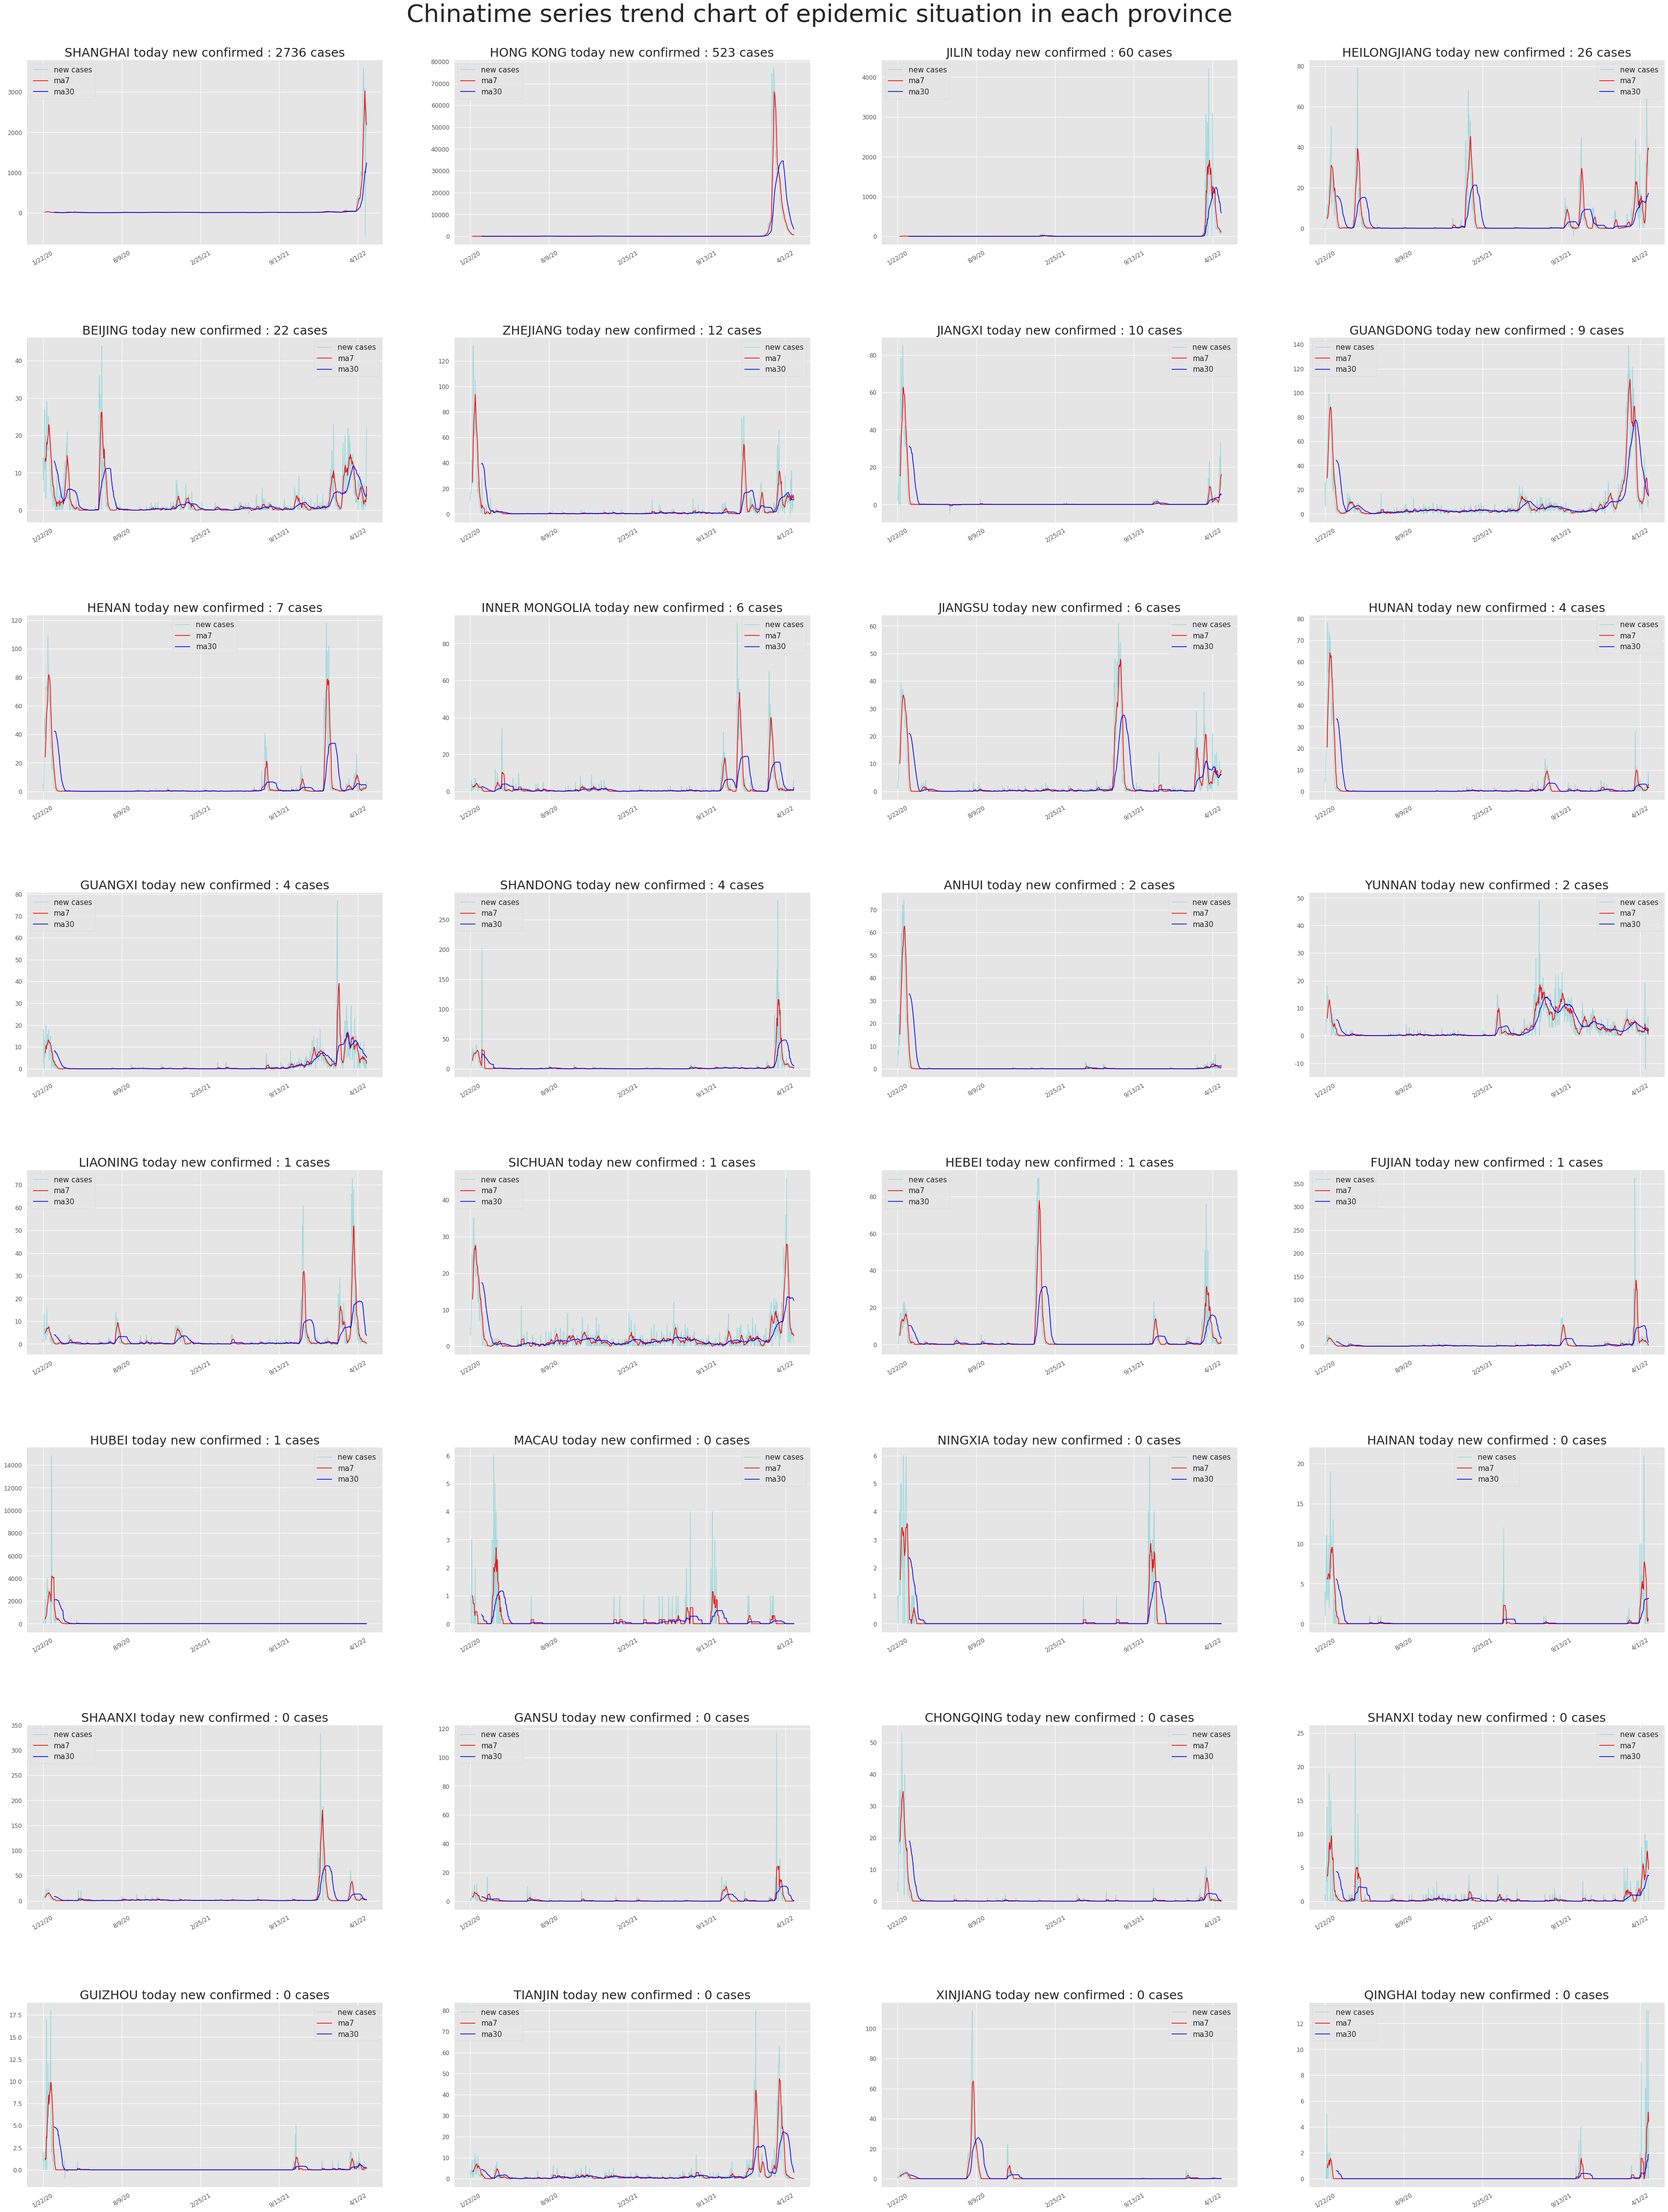

In [20]:
country = 'China'
ma = [7,30]
method = 'new cases'
kind = 'confirmed'

data_copy2 = ts_confirmed_CHINA_incre.copy()
# drop Tibet from the dataset
data_copy2 = data_copy2.drop(labels='Tibet', axis=1)
# data_copy1.tail()

# use ggplot
plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(15*4, 10*8))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(f"{country} time series trend chart of epidemic situation in each province", fontsize=50, y = 0.9)

for province,ax in zip(data_copy2.columns, axs.ravel()):
    data_copy2[province].plot(ax=ax, rot = 30, fontsize = 12, alpha = .3, label = method, color ='#06c3cc')
    # rolling mean: the mean of a certain number of previous periods in a time series
    # df['column_name'].rolling(rolling_window).mean()
    data_copy2[province].rolling(ma[0]).mean().plot(ax=ax, rot = 30, fontsize = 12, label =f'ma{ma[0]}', color ='red')
    data_copy2[province].rolling(ma[1]).mean().plot(ax=ax, rot = 30, fontsize = 12, label =f'ma{ma[1]}', color ='blue')
    ax.set_title(f"{province.upper()} today new {kind} : {int(data_copy2[province].tail(1))} cases", fontsize = 25)
    ax.legend(fontsize = 15)
    ax.set_xlabel('')
plt.show()

In [19]:
data_copy2 = ts_confirmed_US_incre

specify = 'New York'
idx = data_copy2.index
ser = data_copy2[specify]
layout_title = specify.upper()
kind = 'Confirmed'
method = 'new'
ma = [7,30]

trace = go.Scatter(
    x = idx,
    y = ser,
    mode = 'lines+markers',
    name = f'{method} {kind} cases',
    opacity = .8,
    line=dict(color="#08a8c4",width = .4),
    marker = dict(color = '#5857e1',size = 1.2)
)
trace1 = go.Scatter(
    x = idx,
    y = ser.rolling(ma[0]).mean(),
    mode = 'lines+markers',
    # Moving Average
    name = f'{ma[0]}MA',
    opacity = .6,
    line=dict(color="#ee5090",width = 1.4),
    marker = dict(color = '#dd001b',size = 2.2)
)
trace2 = go.Scatter(
    x = idx,
    y = ser.rolling(ma[1]).mean(),
    mode = 'lines+markers',
    name = f'{ma[1]}MA',
    opacity = .8,
    line=dict(color="#006eff",width = 2.4),
    marker = dict(color = '#412b63',size = 3.2)
)


plotdata = [trace,trace1,trace2]

'''启动绘图'''

x_axis_config = {'title': 'date'}
y_axis_config = {'title': f'{kind} cases（{method.upper()}）'}

my_layout = go.Layout(title=f"【{layout_title}】Recent【{kind}】Cases Time Series Plot（{method.upper()}）",
                      xaxis=x_axis_config, yaxis=y_axis_config)
fig = go.Figure(data=plotdata, layout=my_layout)
fig.show()

In [21]:
data_copy2 = ts_confirmed_CHINA_incre

specify = 'Shanghai'
idx = data_copy2.index
ser = data_copy2[specify]
layout_title = specify.upper()
kind = 'Confirmed'
method = 'new'
ma = [7,30]

trace = go.Scatter(
    x = idx,
    y = ser,
    mode = 'lines+markers',
    name = f'{method} {kind} cases',
    opacity = .8,
    line=dict(color="#08a8c4",width = .4),
    marker = dict(color = '#5857e1',size = 1.2)
)
trace1 = go.Scatter(
    x = idx,
    y = ser.rolling(ma[0]).mean(),
    mode = 'lines+markers',
    # Moving Average
    name = f'{ma[0]}MA',
    opacity = .6,
    line=dict(color="#ee5090",width = 1.4),
    marker = dict(color = '#dd001b',size = 2.2)
)
trace2 = go.Scatter(
    x = idx,
    y = ser.rolling(ma[1]).mean(),
    mode = 'lines+markers',
    name = f'{ma[1]}MA',
    opacity = .8,
    line=dict(color="#006eff",width = 2.4),
    marker = dict(color = '#412b63',size = 3.2)
)


plotdata = [trace,trace1,trace2]

'''启动绘图'''

x_axis_config = {'title': 'date'}
y_axis_config = {'title': f'{kind} cases（{method.upper()}）'}

my_layout = go.Layout(title=f"【{layout_title}】Recent【{kind}】Cases Time Series Plot（{method.upper()}）",
                      xaxis=x_axis_config, yaxis=y_axis_config)
fig = go.Figure(data=plotdata, layout=my_layout)
fig.show()